<a href="https://colab.research.google.com/github/sac-1999/Project-1-Intel-Image-Classification/blob/main/Intel_Image_Classification_1907.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## To check GPU alloted specification in google colab





In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-007b937f-8c21-a5b0-c0fd-a35abcb414f0)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=05008f1ecf4cbc34242511061d5b38b833b67e50895d2c863d10584158be91bd
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 118.2 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [4]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models


import tensorflow.keras.optimizers as Optimizer

# Project Description

### **Context**
* This is image data of Natural Scenes around the world.

### **Content**
This Data contains around 25k images of size 150x150 distributed under 6 categories.

* buildings -> 0
* forest    -> 1
* glacier   -> 2
* mountain  -> 3
* sea       -> 4
* street    -> 5 

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [5]:
label_dictionary = {0 : 'buildings',
1 : 'forest',
2 : 'glacier',
3 : 'mountain',
4 : 'sea',
5 : 'street'} 

In [6]:

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
%cd /content/drive/My Drive/Kaggle


/content/drive/My Drive/Kaggle


In [7]:
#!kaggle datasets download -d puneet6060/intel-image-classification

In [8]:
#!unzip \*.zip  && rm *.zip

# Project Pipeline

* getting data from kaggle
* analysing data
* creaating model
* training model

# Analysing data

In [9]:
import os
import pathlib
train_dir = pathlib.Path('/content/drive/MyDrive/Kaggle/seg_train/seg_train')
pred_dir =  pathlib.Path('/content/drive/MyDrive/Kaggle/seg_pred/seg_pred')
test_dir =  pathlib.Path('/content/drive/MyDrive/Kaggle/seg_test/seg_test')


In [10]:
import tensorflow as tf
import glob
import pathlib


print("Total no ofimages available for training {0}:  ". format(len(list(train_dir.glob('*/*.jpg')))))

Total no ofimages available for training 14034:  


# **Data Loading**

## 1. Load Training data

In [11]:
def load_traindata(batch_size, image_size):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               labels='inferred',
                                                               label_mode='int',
                                                               color_mode='rgb',
                                                               image_size=image_size,
                                                               validation_split = 0.2,
                                                               subset = 'training',
                                                               seed = 100,
                                                               batch_size = batch_size)
    
    return train_ds

def load_valdata(batch_size, image_size):
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               labels='inferred',
                                                               label_mode='int',
                                                               color_mode='rgb',
                                                               image_size=image_size,
                                                               validation_split = 0.2,
                                                               subset = 'validation',
                                                               seed = 100,
                                                               batch_size = batch_size)
    

    return val_ds

## 2. Load Test Data

In [12]:
import cv2
from tqdm import tqdm


class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

def load_testdata(image_size):
      
    images = []
    labels = []
    
    
    for folder in os.listdir(test_dir):
        label = class_names_label[folder]
        
        # Iterate through each image in our folder
        for file in tqdm(os.listdir(os.path.join(test_dir, folder))):
            
            # Get the path name of the image
            img_path = os.path.join(os.path.join(test_dir, folder), file)
            
            # Open and resize the img
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size) 
            
            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)
            
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')   
    
    
    return images, labels

## Prefetch and Tuning in Tensorflow

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

## Let's Check if data is balanced or not

<BarContainer object of 6 artists>

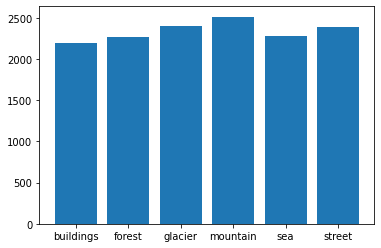

In [14]:
# so we will count the no of images present for each category in training directory and if counts matches roughly then data is balanced 
# If there is huge difference in counts of individual category then we should use various technique to handle imabalance dataset like 
# undersampling, oversampling , focal loss we will surely discuss these techniques in blog post let's Go ------

import matplotlib.pyplot as plt

list_of_category = [str(category).split('/')[-1]  for category in list(train_dir.glob('*'))]
list_of_category  #  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

total_count = []
for category in list_of_category:
    l = list(pathlib.Path(os.path.join(train_dir,category)).glob('*'))
    total_count.append(len(l))
    
plt.bar(list_of_category,total_count )

# Output shows that dataset is almost balanced yeaahhhhhh!!!

## Show Sample images

In [15]:
import matplotlib.pyplot as plt

def show_sampleimages(dataset):

    plt.figure(figsize=(10, 10))
    ## take(count) where count is the no of random examples should be taken from dataset
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(label_dictionary[int(labels[i])])
            plt.axis("off")

## Tensorboard Setup


In [ ]:
import tensorflow as tf
import datetime

%reload_ext tensorboard

# Clear any logs from previous runs
#rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Create basic model

In [ ]:
def create_model():

    model = Models.Sequential()

    model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
    model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
    model.add(Layers.MaxPool2D(5,5))
    model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
    model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
    model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
    model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
    model.add(Layers.MaxPool2D(5,5))
    model.add(Layers.Flatten())
    model.add(Layers.Dense(180,activation='relu'))
    model.add(Layers.Dense(100,activation='relu'))
    model.add(Layers.Dense(50,activation='relu'))
    model.add(Layers.Dropout(rate=0.5))
    model.add(Layers.Dense(6,activation='softmax'))

    return model


# **Attempt 1:-**

Achieved around 83% validation accuracy

In [ ]:
batch_size = 32
image_size = (150,150)
train_ds = load_traindata(batch_size, image_size)
val_ds = load_valdata(batch_size, image_size)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [ ]:
model = create_model()
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_ds, epochs = 13, verbose=1,validation_data = val_ds, callbacks=[tensorboard_callbacks] )

Epoch 1/13
351/351 [==============================] - 381s 1s/step - loss: 1.2216 - accuracy: 0.5204 - val_loss: 0.9458 - val_accuracy: 0.6258
Epoch 2/13
351/351 [==============================] - 45s 129ms/step - loss: 1.0108 - accuracy: 0.6203 - val_loss: 0.7752 - val_accuracy: 0.7270
Epoch 3/13
351/351 [==============================] - 45s 128ms/step - loss: 0.8590 - accuracy: 0.6910 - val_loss: 0.6977 - val_accuracy: 0.7427
Epoch 4/13
351/351 [==============================] - 45s 129ms/step - loss: 0.7796 - accuracy: 0.7272 - val_loss: 0.6157 - val_accuracy: 0.7833
Epoch 5/13
351/351 [==============================] - 45s 128ms/step - loss: 0.7161 - accuracy: 0.7488 - val_loss: 0.5838 - val_accuracy: 0.7929
Epoch 6/13
351/351 [==============================] - 45s 128ms/step - loss: 0.6568 - accuracy: 0.7705 - val_loss: 0.6250 - val_accuracy: 0.7869
Epoch 7/13
351/351 [==============================] - 45s 128ms/step - loss: 0.6204 - accuracy: 0.7840 - val_loss: 0.5365 - val_accu

In [ ]:
%tensorboard --logdir logs/fit

## Accuray and Loss Plot

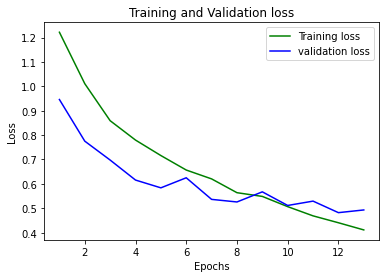

In [ ]:
def plot_loss(loss_train, loss_val):
    epochs = range(1,len(loss_train)+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

loss_train = history1.history['loss']
loss_val = history1.history['val_loss']
plot_loss(loss_train, loss_val)

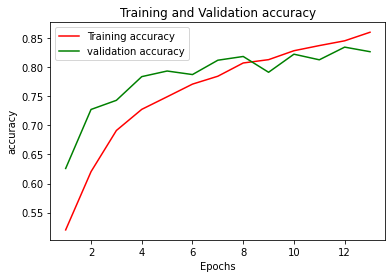

In [ ]:
def plot_accuracy(accuracy_train, accuracy_val):
    epochs = range(1,len(accuracy_train)+1)
    plt.plot(epochs, accuracy_train, 'r', label='Training accuracy')
    plt.plot(epochs, accuracy_val, 'g', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

accuracy_train = history1.history['accuracy']
accuracy_val = history1.history['val_accuracy']
plot_accuracy(accuracy_train, accuracy_val)

In [49]:
def test_prediction(model):
    images, true_labels = load_testdata(image_size)
    pred = model.predict(images)
    pred_labels = np.argmax(pred , axis = 1)

    confusion = sklearn.metrics.confusion_matrix(true_labels, pred_labels)
    
    return confusion

In [ ]:
cf_mat = test_prediction(model)

## Loss Graph Insights

at epoch = 10 Model starts overfitting so we can also use early stopping call backs to avoid overfitting the model.

## Attempt 2 :-
Model with batch normalisation layers

it took on average 53 s for each epoch but accuracy was still arround 83

In [ ]:
from tensorflow.keras.layers import BatchNormalization
def create_model2():

    model = Models.Sequential()

    model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
    model.add(BatchNormalization())
    model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Layers.MaxPool2D(5,5))
    model.add(BatchNormalization())
    model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Layers.MaxPool2D(5,5))
    model.add(BatchNormalization())
    model.add(Layers.Flatten())
    model.add(Layers.Dense(180,activation='relu'))
    model.add(Layers.Dense(100,activation='relu'))
    model.add(Layers.Dense(50,activation='relu'))
    model.add(Layers.Dropout(rate=0.5))
    model.add(Layers.Dense(6,activation='softmax'))

    return model

In [ ]:
model2 = create_model2()

model2.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_ds, epochs = 15, verbose=1,validation_data = val_ds)


Epoch 1/15
351/351 [==============================] - 54s 152ms/step - loss: 1.3462 - accuracy: 0.4746 - val_loss: 0.8726 - val_accuracy: 0.6857
Epoch 2/15
351/351 [==============================] - 53s 152ms/step - loss: 0.9035 - accuracy: 0.6935 - val_loss: 0.6660 - val_accuracy: 0.7680
Epoch 3/15
351/351 [==============================] - 53s 152ms/step - loss: 0.7311 - accuracy: 0.7618 - val_loss: 0.5767 - val_accuracy: 0.7986
Epoch 4/15
351/351 [==============================] - 53s 151ms/step - loss: 0.6295 - accuracy: 0.7926 - val_loss: 0.5444 - val_accuracy: 0.8004
Epoch 5/15
351/351 [==============================] - 53s 151ms/step - loss: 0.5605 - accuracy: 0.8154 - val_loss: 0.5441 - val_accuracy: 0.8008
Epoch 6/15
351/351 [==============================] - 53s 152ms/step - loss: 0.5040 - accuracy: 0.8391 - val_loss: 0.5129 - val_accuracy: 0.8168
Epoch 7/15
351/351 [==============================] - 53s 151ms/step - loss: 0.4437 - accuracy: 0.8580 - val_loss: 0.5115 - val_ac

Model Overfitting

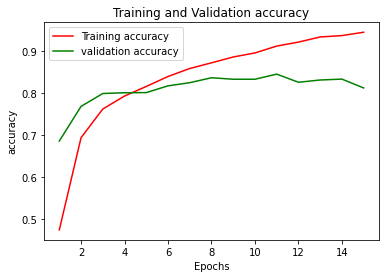

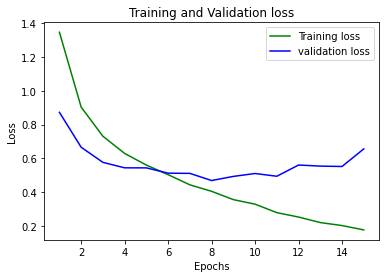

In [ ]:

plot_accuracy(history2.history['accuracy'], history2.history['val_accuracy'])

plot_loss(history2.history['loss'], history2.history['val_loss'])

## Attempt 3:

using callbacks(learning rate scheduler) in model no 2 to reduce overfitting

In [ ]:
def lr_reshedule(epoch,learning_rate):
    if(epoch > 8):
        return learning_rate * 0.5

    else:
        return learning_rate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_reshedule, verbose=0)

model3 = create_model2()

model3.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_ds, epochs = 15, verbose=1,validation_data = val_ds,callbacks = [lr_scheduler])

Epoch 1/15
351/351 [==============================] - 54s 152ms/step - loss: 1.3049 - accuracy: 0.4805 - val_loss: 0.8726 - val_accuracy: 0.6818
Epoch 2/15
351/351 [==============================] - 53s 152ms/step - loss: 0.8872 - accuracy: 0.6815 - val_loss: 0.6726 - val_accuracy: 0.7463
Epoch 3/15
351/351 [==============================] - 53s 152ms/step - loss: 0.7314 - accuracy: 0.7482 - val_loss: 0.6180 - val_accuracy: 0.7744
Epoch 4/15
351/351 [==============================] - 53s 152ms/step - loss: 0.6289 - accuracy: 0.7854 - val_loss: 0.5291 - val_accuracy: 0.8051
Epoch 5/15
351/351 [==============================] - 53s 152ms/step - loss: 0.5557 - accuracy: 0.8119 - val_loss: 0.5161 - val_accuracy: 0.8197
Epoch 6/15
351/351 [==============================] - 53s 152ms/step - loss: 0.5072 - accuracy: 0.8294 - val_loss: 0.5032 - val_accuracy: 0.8239
Epoch 7/15
351/351 [==============================] - 53s 152ms/step - loss: 0.4419 - accuracy: 0.8540 - val_loss: 0.5088 - val_ac

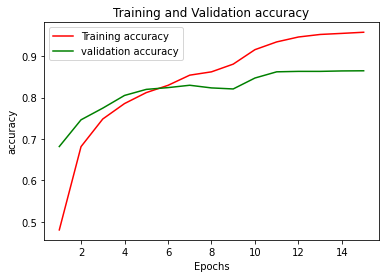

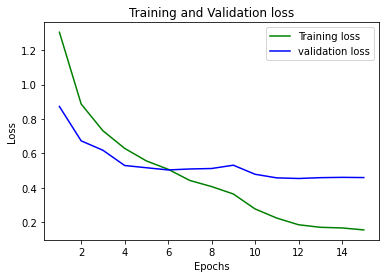

In [ ]:
plot_accuracy(history3.history['accuracy'], history3.history['val_accuracy'])
plot_loss(history3.history['loss'], history3.history['val_loss'])

## Attempt - 4

### Using pretrained Mobilenetv2

In [ ]:
image_size = (160,160)
image_shape = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
batch_size = 32
train_ds = load_traindata(batch_size, image_size)
val_ds = load_valdata(batch_size, image_size)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(160,160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(6, activation = 'Softmax')(x)
model4 = tf.keras.Model(inputs, outputs)

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
def lr_reshedule(epoch,learning_rate):
    if(epoch % 2 == 0 ):
        return learning_rate*1.
    else:
        return learning_rate

lr_scheduler_on_pretrained = tf.keras.callbacks.LearningRateScheduler(lr_reshedule, verbose=2)

In [ ]:
history4 = model4.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds,
                    verbose = 1,
                    callbacks = [lr_scheduler_on_pretrained])

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 7.499999810534064e-05.
351/351 [==============================] - 15s 37ms/step - loss: 1.1191 - accuracy: 0.5846 - val_loss: 0.6061 - val_accuracy: 0.8215
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 7.499999628635123e-05.
351/351 [==============================] - 7s 21ms/step - loss: 0.5242 - accuracy: 0.8229 - val_loss: 0.4208 - val_accuracy: 0.8610
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011249999442952685.
351/351 [==============================] - 7s 21ms/step - loss: 0.3898 - accuracy: 0.8612 - val_loss: 0.3414 - val_accuracy: 0.8877
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00011249999806750566.
351/351 [==============================] - 7s 21ms/step - loss: 0.3261 - accuracy: 0.8817 - val_loss: 0.3092 - val_accuracy: 0.8981
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0001687499

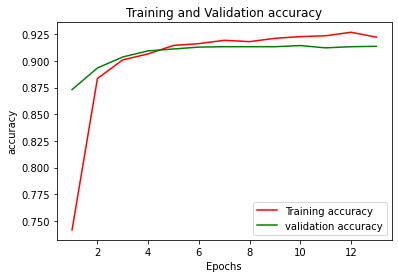

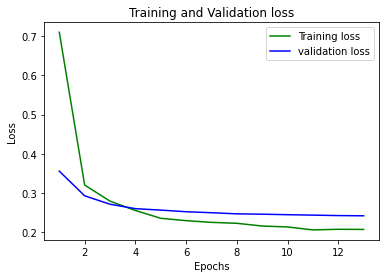

In [ ]:
plot_accuracy(history4.history['accuracy'], history4.history['val_accuracy'])
plot_loss(history4.history['loss'], history4.history['val_loss'])

Almost achieved 92 %

## Attempt 5 :- 

Trying to make last few layers of base modeltrainable

In [ ]:
model6 = tf.keras.Model(inputs, outputs)

In [ ]:
model6.layers[3].layers[-1].trainable = True
model6.layers[3].layers[-2].trainable = True
model6.layers[3].layers[-3].trainable = True

In [ ]:
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_ds,
                    epochs=13,
                    validation_data=val_ds,
                    verbose = 1,
                    callbacks = [lr_scheduler_on_pretrained])

Epoch 1/13

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
351/351 [==============================] - 10s 22ms/step - loss: 0.2062 - accuracy: 0.9246 - val_loss: 0.2384 - val_accuracy: 0.9152
Epoch 2/13

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
351/351 [==============================] - 7s 21ms/step - loss: 0.1997 - accuracy: 0.9280 - val_loss: 0.2383 - val_accuracy: 0.9159
Epoch 3/13

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
351/351 [==============================] - 7s 21ms/step - loss: 0.1921 - accuracy: 0.9298 - val_loss: 0.2373 - val_accuracy: 0.9173
Epoch 4/13

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001250000059371814.
351/351 [==============================] - 7s 21ms/step - loss: 0.1838 - accuracy: 0.9329 - val_loss: 0.2351 - val_accuracy: 0.9163
Epoch 5/13

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000125000005

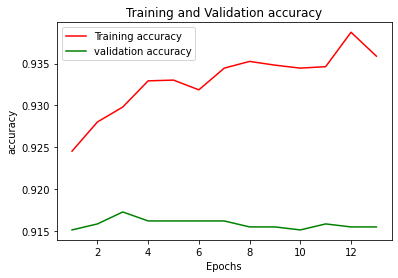

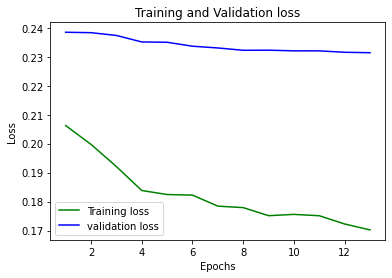

In [ ]:
plot_accuracy(history6.history['accuracy'], history6.history['val_accuracy'])
plot_loss(history6.history['loss'], history6.history['val_loss'])



--- Did Not work at allin this case as accuracy is still 91



Making last 3 layers trainable for base model din not impact much on accuracy 

## Attempt 7 :- (VGG Architecture)
Taking some other state of art pretrainde model

In [38]:
image_size = (224,224)
image_shape = image_size + (3,)

base_model = tf.keras.applications.EfficientNetB7(input_shape=image_shape,
    include_top=False,
    weights="imagenet")

258080768/258076736 [==============================] - 2s 0us/step


In [39]:
batch_size = 32
train_ds = load_traindata(batch_size, image_size)
val_ds = load_valdata(batch_size, image_size)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [42]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
base_model.trainable = False

In [43]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(6, activation = 'Softmax')(x)
model7 = tf.keras.Model(inputs, outputs)

In [44]:
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
history7 = model7.fit(train_ds,
                    epochs=13,
                    validation_data=val_ds,
                    verbose = 1)

Epoch 1/13
351/351 [==============================] - 160s 456ms/step - loss: 0.4102 - accuracy: 0.8733 - val_loss: 0.2983 - val_accuracy: 0.8945
Epoch 2/13
351/351 [==============================] - 158s 450ms/step - loss: 0.2623 - accuracy: 0.9083 - val_loss: 0.2630 - val_accuracy: 0.9066
Epoch 3/13
351/351 [==============================] - 158s 449ms/step - loss: 0.2330 - accuracy: 0.9160 - val_loss: 0.2495 - val_accuracy: 0.9105
Epoch 4/13
351/351 [==============================] - 158s 449ms/step - loss: 0.2155 - accuracy: 0.9235 - val_loss: 0.2408 - val_accuracy: 0.9130
Epoch 5/13
351/351 [==============================] - 158s 450ms/step - loss: 0.2032 - accuracy: 0.9270 - val_loss: 0.2353 - val_accuracy: 0.9145
Epoch 6/13
351/351 [==============================] - 158s 449ms/step - loss: 0.1948 - accuracy: 0.9302 - val_loss: 0.2310 - val_accuracy: 0.9163
Epoch 7/13
351/351 [==============================] - 158s 449ms/step - loss: 0.1871 - accuracy: 0.9328 - val_loss: 0.2283 -

In [ ]:
cf = test_prediction(model7)

 86%|████████▋ | 440/510 [02:27<00:25,  2.70it/s]